In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns

In [2]:
train_data=pd.read_csv('/home/ette/Desktop/Gesture_Classification_Accelerometer/Datase_ Built/train_data.csv')
val_data=pd.read_csv('/home/ette/Desktop/Gesture_Classification_Accelerometer/Datase_ Built/val_data.csv')
test_data=pd.read_csv('/home/ette/Desktop/Gesture_Classification_Accelerometer/Datase_ Built/test_data.csv')

In [3]:
x_train=train_data.drop(['label'], axis=1)
y_train=train_data['label']

x_val=val_data.drop(['label'], axis=1)
y_val=val_data['label']

x_test=test_data.drop(['label'], axis=1)
y_test=test_data['label']

In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models, optimizers

2025-04-24 02:18:15.419087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 02:18:15.419654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 02:18:15.421881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 02:18:15.428203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745439495.439035  149831 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745439495.44

In [6]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads, ff_dim, input_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(input_dim)  # Match the input dimension for residual connection
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, inputs, training=None):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer Model for Tabular Data
def build_transformer_model(input_dim, output_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate):
    inputs = layers.Input(shape=(input_dim,))
    
    # Reshape to 3D for multi-head attention
    x = layers.Reshape((1, input_dim))(inputs)
    
    # Stack Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = TransformerEncoder(num_heads, ff_dim, input_dim, dropout_rate)(x)
    
    x = layers.Flatten()(x)
    
    # Output layer for classification
    outputs = layers.Dense(output_dim, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
# Hyperparameters
input_dim = x_train.shape[1]  # Number of features
output_dim = len(y_train.unique())  # Number of classes for classification
num_heads = 8
ff_dim = 64
num_transformer_blocks = 4
dropout_rate = 0.1
learning_rate = 0.001
batch_size = 32
num_epochs = 400

In [8]:
model = build_transformer_model(input_dim, output_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2025-04-24 02:18:16.736403: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
history=model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (x_val, y_val))

Epoch 1/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3588 - loss: 1.7938 - val_accuracy: 0.5105 - val_loss: 1.3780
Epoch 2/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5007 - loss: 1.3336 - val_accuracy: 0.5787 - val_loss: 1.1285
Epoch 3/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5426 - loss: 1.2491 - val_accuracy: 0.5315 - val_loss: 1.1437
Epoch 4/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5779 - loss: 1.1415 - val_accuracy: 0.6171 - val_loss: 1.0423
Epoch 5/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5832 - loss: 1.1118 - val_accuracy: 0.6241 - val_loss: 1.0663
Epoch 6/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6174 - loss: 1.0416 - val_accuracy: 0.6399 - val_loss: 0.9898
Epoch 7/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6275 - loss: 1.0064 - val_accuracy: 0.6189 - val_loss: 1.0061
Epoch 8/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6218 - loss: 1.0024 - val_accuracy: 0.6224 - 

Epoch 59/400
82/82 [==============================] - 1s 6ms/step - loss: 0.4091 - accuracy: 0.8493 - val_loss: 0.7816 - val_accuracy: 0.7637
Epoch 60/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3968 - accuracy: 0.8474 - val_loss: 0.7495 - val_accuracy: 0.7584
Epoch 61/400
82/82 [==============================] - 1s 6ms/step - loss: 0.4019 - accuracy: 0.8477 - val_loss: 0.8544 - val_accuracy: 0.7447
Epoch 62/400
82/82 [==============================] - 1s 6ms/step - loss: 0.3863 - accuracy: 0.8539 - val_loss: 0.7958 - val_accuracy: 0.7647
Epoch 63/400
82/82 [==============================] - 1s 7ms/step - loss: 0.3847 - accuracy: 0.8546 - val_loss: 0.7627 - val_accuracy: 0.7700
Epoch 64/400
82/82 [==============================] - 0s 6ms/step - loss: 0.3667 - accuracy: 0.8715 - val_loss: 0.7762 - val_accuracy: 0.7542
Epoch 65/400
82/82 [==============================] - 1s 6ms/step - loss: 0.3988 - accuracy: 0.8481 - val_loss: 0.7893 - val_accuracy: 0.7489
Epoch 

82/82 [==============================] - 0s 6ms/step - loss: 0.2500 - accuracy: 0.9105 - val_loss: 0.8931 - val_accuracy: 0.7710
Epoch 117/400
82/82 [==============================] - 0s 6ms/step - loss: 0.2283 - accuracy: 0.9231 - val_loss: 0.8647 - val_accuracy: 0.7763
Epoch 118/400
82/82 [==============================] - 0s 6ms/step - loss: 0.2807 - accuracy: 0.9013 - val_loss: 0.8369 - val_accuracy: 0.7731
Epoch 119/400
82/82 [==============================] - 0s 6ms/step - loss: 0.2120 - accuracy: 0.9174 - val_loss: 0.8048 - val_accuracy: 0.7899
Epoch 120/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1843 - accuracy: 0.9357 - val_loss: 0.8615 - val_accuracy: 0.7784
Epoch 121/400
82/82 [==============================] - 0s 6ms/step - loss: 0.2622 - accuracy: 0.9024 - val_loss: 0.8815 - val_accuracy: 0.7773
Epoch 122/400
82/82 [==============================] - 0s 6ms/step - loss: 0.2227 - accuracy: 0.9132 - val_loss: 0.8640 - val_accuracy: 0.7721
Epoch 123/400

82/82 [==============================] - 0s 6ms/step - loss: 0.1975 - accuracy: 0.9281 - val_loss: 0.9764 - val_accuracy: 0.7815
Epoch 174/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1993 - accuracy: 0.9265 - val_loss: 0.9955 - val_accuracy: 0.7626
Epoch 175/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1827 - accuracy: 0.9357 - val_loss: 0.9106 - val_accuracy: 0.7773
Epoch 176/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1449 - accuracy: 0.9480 - val_loss: 0.8932 - val_accuracy: 0.8036
Epoch 177/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1494 - accuracy: 0.9434 - val_loss: 0.8328 - val_accuracy: 0.7920
Epoch 178/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1405 - accuracy: 0.9480 - val_loss: 0.9420 - val_accuracy: 0.7721
Epoch 179/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1663 - accuracy: 0.9419 - val_loss: 0.9086 - val_accuracy: 0.7794
Epoch 180/400

82/82 [==============================] - 0s 6ms/step - loss: 0.1204 - accuracy: 0.9552 - val_loss: 1.0845 - val_accuracy: 0.7700
Epoch 231/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1186 - accuracy: 0.9575 - val_loss: 0.9736 - val_accuracy: 0.7826
Epoch 232/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1234 - accuracy: 0.9552 - val_loss: 1.1003 - val_accuracy: 0.7679
Epoch 233/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1123 - accuracy: 0.9591 - val_loss: 1.0237 - val_accuracy: 0.7920
Epoch 234/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1324 - accuracy: 0.9541 - val_loss: 1.0126 - val_accuracy: 0.7784
Epoch 235/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1158 - accuracy: 0.9579 - val_loss: 1.0861 - val_accuracy: 0.7668
Epoch 236/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1507 - accuracy: 0.9449 - val_loss: 0.9944 - val_accuracy: 0.7784
Epoch 237/400

82/82 [==============================] - 0s 6ms/step - loss: 0.1042 - accuracy: 0.9614 - val_loss: 0.9917 - val_accuracy: 0.7941
Epoch 288/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1186 - accuracy: 0.9579 - val_loss: 1.0387 - val_accuracy: 0.7763
Epoch 289/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1366 - accuracy: 0.9491 - val_loss: 0.9628 - val_accuracy: 0.7910
Epoch 290/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1106 - accuracy: 0.9575 - val_loss: 1.0368 - val_accuracy: 0.7941
Epoch 291/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1088 - accuracy: 0.9564 - val_loss: 1.1231 - val_accuracy: 0.7868
Epoch 292/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1115 - accuracy: 0.9602 - val_loss: 1.0187 - val_accuracy: 0.7868
Epoch 293/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1230 - accuracy: 0.9541 - val_loss: 1.0502 - val_accuracy: 0.7710
Epoch 294/400

82/82 [==============================] - 0s 6ms/step - loss: 0.1372 - accuracy: 0.9537 - val_loss: 0.9627 - val_accuracy: 0.7899
Epoch 345/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1143 - accuracy: 0.9564 - val_loss: 1.0832 - val_accuracy: 0.7910
Epoch 346/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.9663 - val_loss: 0.9839 - val_accuracy: 0.7920
Epoch 347/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0793 - accuracy: 0.9690 - val_loss: 1.1236 - val_accuracy: 0.7773
Epoch 348/400
82/82 [==============================] - 0s 6ms/step - loss: 0.1295 - accuracy: 0.9510 - val_loss: 1.0386 - val_accuracy: 0.7899
Epoch 349/400
82/82 [==============================] - 0s 6ms/step - loss: 0.0819 - accuracy: 0.9705 - val_loss: 1.0364 - val_accuracy: 0.7920
Epoch 350/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1096 - accuracy: 0.9614 - val_loss: 1.1333 - val_accuracy: 0.7805
Epoch 351/400

In [10]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 33)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 1, 33)          │        40,126 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 1, 33)          │        40,126 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 1, 33)          │        40,126 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 1, 33)          │        40,126 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,330 (1.84 MB)

 Trainable params: 160,776 (628.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 321,554 (1.23 MB)

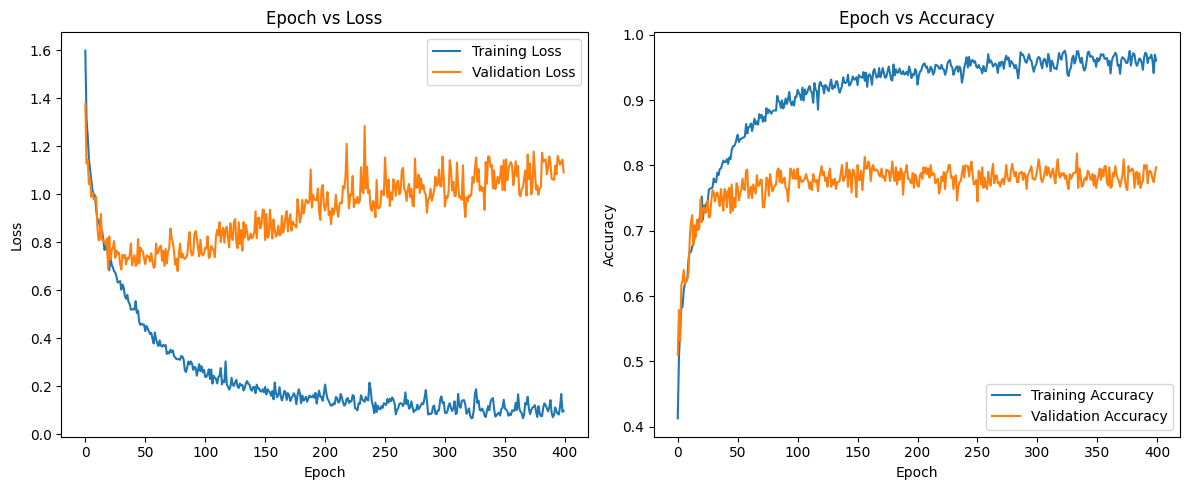

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 98.89%
Test Accuracy: 77.72%


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


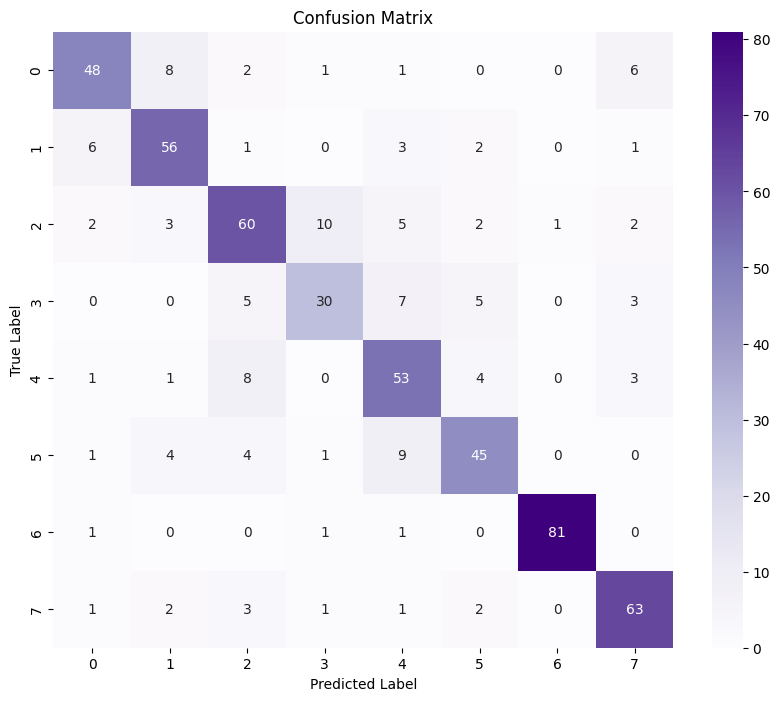

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        66
           1       0.76      0.81      0.78        69
           2       0.72      0.71      0.71        85
           3       0.68      0.60      0.64        50
           4       0.66      0.76      0.71        70
           5       0.75      0.70      0.73        64
           6       0.99      0.96      0.98        84
           7       0.81      0.86      0.83        73

    accuracy                           0.78       561
   macro avg       0.77      0.77      0.77       561
weighted avg       0.78      0.78      0.78       561



In [13]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    y_true = y_test  
else:
    y_true = np.argmax(y_test, axis=1)  


conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(len(np.unique(y_true)))])
print("Classification Report:")
print(class_report)